In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler

from pyfrechet.metric_spaces import MetricData, Sphere, Torus
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

from geomstats.geometry.hypersphere import Hypersphere

INFO: Using numpy backend


# Simulation study of OOB Balls


## Syntetic Data on the Circle


### Sample 1

In [31]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='S1Data_sample1.csv'
sample1=pd.read_csv(path+file_name)
sample1.head()

theta         t
0 -0.435467  0.004075
1 -0.554753  0.004548
2 -0.371468  0.006390
3 -0.403668  0.008407
4 -0.314433  0.009653

In [32]:
M=Sphere(1)
X=sample1[['t']].values
y=MetricData(M, Hypersphere(dim=1).angle_to_extrinsic(sample1[['theta']].values)[:,0,:])

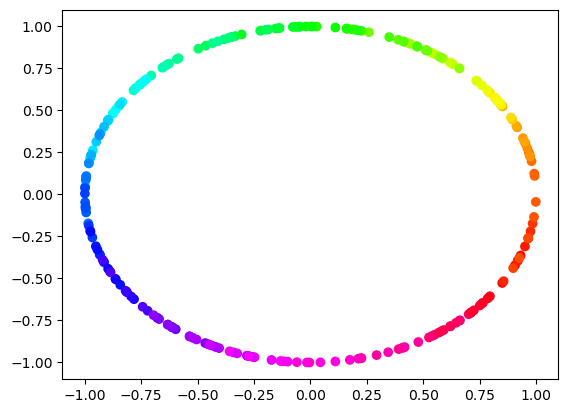

In [33]:
plt.figure()
plt.scatter(y.data[:,0], y.data[:,1], label='Reference', c=np.arange(y.data.shape[0]), cmap='hsv')
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [35]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=-2)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(split_type='2means'))

In [36]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

MSE: 0.01884110808312998


In [177]:
forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.014144509761041936


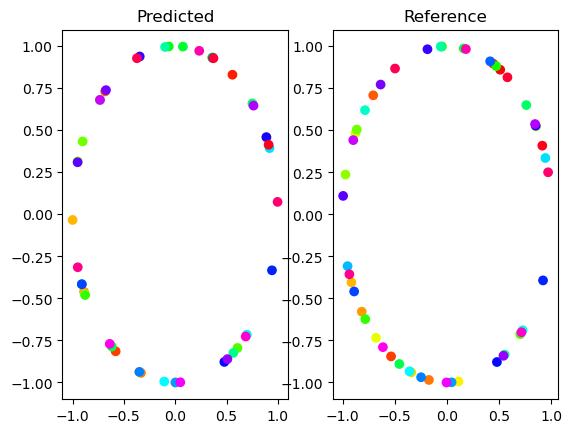

In [183]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(forest_predictions.data[:,0], forest_predictions.data[:,1], c=np.arange(y_test.data.shape[0]), cmap='hsv')
ax[0].set_title('Predicted')
ax[1].scatter(y_test.data[:,0], y_test.data[:,1], c=np.arange(y_test.data.shape[0]), cmap='hsv')
ax[1].set_title('Reference')
plt.show()

In [37]:
oob_errors=forest.oob_errors()

## Syntetic data on the Sphere


### Sample 1


In [57]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='S2Data_sample1.csv'
sample1=pd.read_csv(path+file_name)
print(sample1.head())
print(sample1.shape)

     samp.1    samp.2    samp.3        th
0  0.756882 -0.136294  0.639182 -3.138099
1  0.816008  0.384900  0.431258 -3.123721
2  0.740588  0.606615  0.289047 -3.100732
3  0.791025  0.407890  0.455965 -3.082722
4  0.798165  0.272547  0.537262 -3.077516
(400, 4)


In [58]:
sample1.describe()

samp.1      samp.2      samp.3          th
count  400.000000  400.000000  400.000000  400.000000
mean    -0.009310    0.009323    0.033876   -0.076656
std      0.661097    0.455657    0.597084    1.819008
min     -0.998874   -0.967991   -0.998683   -3.138099
25%     -0.648914   -0.352700   -0.522656   -1.679453
50%      0.002692    0.011705    0.034936   -0.198690
75%      0.624550    0.376403    0.584495    1.524119
max      0.997672    0.997103    0.983864    3.127980

In [59]:
M=Sphere(2)
X=sample1[['th']].values
#X=(np.arange(sample1.shape[0])/sample1.shape[0]).reshape((-1,1))
#y=MetricData(M, Hypersphere(dim=2).spherical_to_extrinsic(sample1[['samp.2', 'samp.1']].values))
y=MetricData(M, sample1[['samp.1', 'samp.2', 'samp.3']].values)

In [60]:
y.data

array([[ 0.75688204, -0.13629398,  0.63918192],
       [ 0.81600764,  0.38489962,  0.43125841],
       [ 0.74058783,  0.60661464,  0.2890473 ],
       ...,
       [ 0.77638562,  0.58191231,  0.24208146],
       [ 0.73673563, -0.21012053,  0.6427052 ],
       [ 0.74186784,  0.63966641,  0.20114421]])

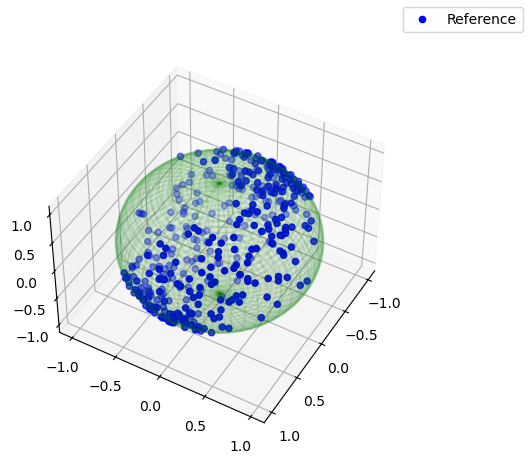

In [62]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(y.data[:,0],
            y.data[:,1],
            y.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=45, azim=30)
fig.legend()

plt.show()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [90]:
train_idx, test_idx = train_test_split(np.arange(len(X)), test_size=0.25)
X_train=X[train_idx]
X_test=X[test_idx]
y_train=y[train_idx]
y_test=y[test_idx]

In [103]:
# print(train_idx)
# print(test_idx)
print(np.concatenate((train_idx, test_idx)))
np.concatenate((train_idx, test_idx)).shape

[323  31 390 236 283 393 178 291 378  26 126 358 146 310 194  91 226  41
  18 271 210 346 321 280 294 293 287 105  97 125 286 175 169  59 181 225
   1 265 304 303 351 160 375 183 396 167   0 356 155  13 394 381 122 100
  83  25  98 203  74 240 314 278 268 206 130 302  93 389 235  51 292 337
 281 385 329  47 166   9 355   7 308 254  70 350  75  73 119 228 114 318
 363 336 127   4 392 138 197 208 282 380 366  79 234 332  37 285 153 243
  66 128 112 324 368 275 184 196  63 325  17 176 108 331  54 121  86 327
  14 279 245 149  22  11  81 216 305  85 335 322 143 262 353 343 296 320
 188  24   8 214 391  10 299 257  69  80 158 307 140 313 330 333 274 270
  89  88 200 165 230 284 173  45 185  65 384  16 250  71  36 145  67  92
 171 159 369 199 359 361  52 326 229 328 157 223 142 132 242  72  23 209
 168 106 246  12  39 315 148 273 342 144 113 276  21  35 253 267 295  64
 347 382  50 192 103 131  34 102 251 179  90 306  84 198 239 357 174 395
  43 374 215  33  76  56 248 319 309 232 290 370 15

(400,)

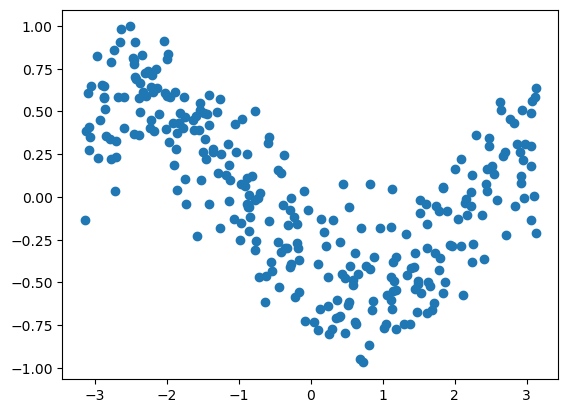

In [86]:
plt.figure()
plt.scatter(X_train, y_train.data[:,1])
plt.show()


In [91]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=-2)
forest.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  2.3min finished


BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(split_type='2means'))

In [92]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

MSE: 0.11847403544178656


In [105]:
type(forest_predictions)

pyfrechet.metric_spaces.sphere.Sphere

In [93]:
forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.08358817023903112


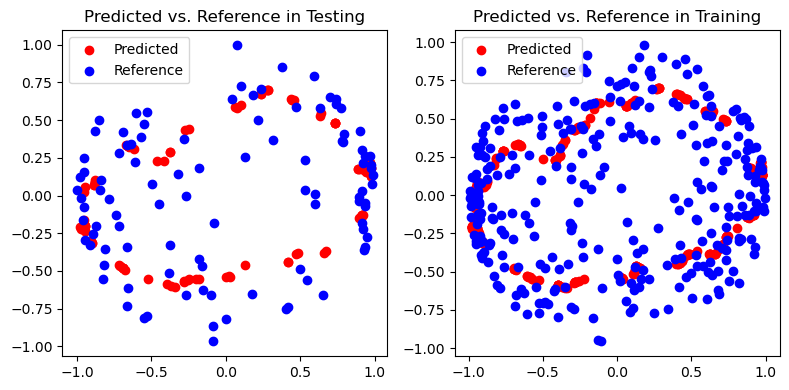

In [94]:

fig, axs=plt.subplots(1,2, figsize=(8,4))
axs[0].scatter(forest_predictions.data[:,0], forest_predictions.data[:,1], color='red', label='Predicted')
axs[0].scatter(y_test.data[:,0], y_test.data[:,1], color='blue', label='Reference')
axs[0].legend()
axs[0].set_title('Predicted vs. Reference in Testing')
axs[1].scatter(forest_fitted.data[:,0], forest_fitted.data[:,1], color='red', label='Predicted')
axs[1].scatter(y_train.data[:,0], y_train.data[:,1], color='blue', label='Reference')
axs[1].legend()
axs[1].set_title('Predicted vs. Reference in Training')
plt.tight_layout()
plt.show()

In [95]:
print(y_test.data[:5,:])
print(forest_predictions.data[:5,:])
print(np.linalg.norm(forest_predictions.data[:5,:], axis=1)) # Check that predictions are on the unit sphere

[[ 0.91872445 -0.22404642  0.32519008]
 [ 0.97975878  0.07777509 -0.18445534]
 [-0.73602902 -0.13051011 -0.66425024]
 [-0.54901461 -0.81178355 -0.19897344]
 [-0.81101273 -0.35356039 -0.46610449]]
[[ 0.97017025  0.21683452 -0.10840879]
 [ 0.97815267  0.12971786 -0.16245196]
 [-0.68829036 -0.48249888 -0.54171137]
 [-0.6878681  -0.48259602 -0.54216101]
 [-0.7163488  -0.46381262 -0.52126985]]
[1. 1. 1. 1. 1.]


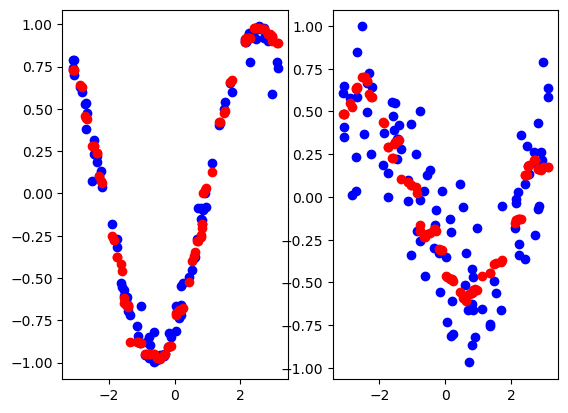

In [96]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(X_test, y_test.data[:,0], color='blue', label='Reference')
ax[0].scatter(X_test, forest_predictions.data[:,0], color='red', label='Prediction')
ax[1].scatter(X_test, y_test.data[:,1], color='blue', label='Reference')
ax[1].scatter(X_test, forest_predictions.data[:,1], color='red', label='Prediction')
plt.show()

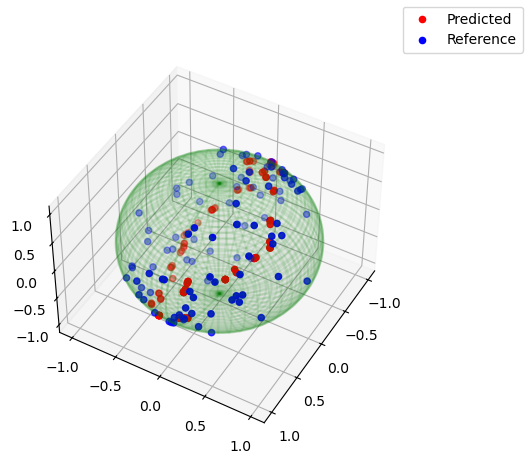

In [97]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[:,0],
            forest_predictions.data[:,1],
            forest_predictions.data[:,2], color='red', label='Predicted')
y_test_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(y_test.data)
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=45, azim=30)
fig.legend()

plt.show()

In [98]:
# Quantile for confidence balls
alpha=0.05
Dalpha=np.percentile(forest.oob_errors(), (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.93

### Sample 2

In [3]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='S2Data_sample2.csv'
sample1=pd.read_csv(path+file_name)
print(sample1.head())
print(sample1.shape)

     samp.1    samp.2        ph
0  1.599907  4.712303  0.001963
1  1.582323  4.709308  0.019794
2  1.576008  4.712145  0.025810
3  1.572362  4.709550  0.029625
4  1.568931  4.712228  0.032883
(400, 3)


In [4]:
M=Sphere(2)
X=sample1[['ph']].values
# X=(np.arange(sample1.shape[0])/sample1.shape[0]).reshape((-1,1))
y=MetricData(M, Hypersphere(dim=2).spherical_to_extrinsic(sample1[['samp.2', 'samp.1']].values))

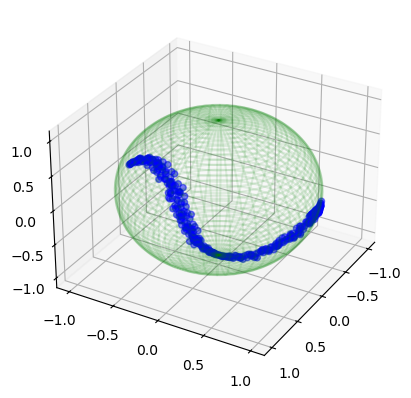

In [6]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100, endpoint=False)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(y.data[:,0],
            y.data[:,1],
            y.data[:,2], color='blue', #label='Reference',
            alpha=0.5)
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=30, azim=30)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# fig.legend()

plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [32]:
base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=None,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=-2)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(impurity_method='medoid', split_type='2means'))

In [33]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

MSE: 0.0033261437436116676


In [34]:
forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.0021488546843390537


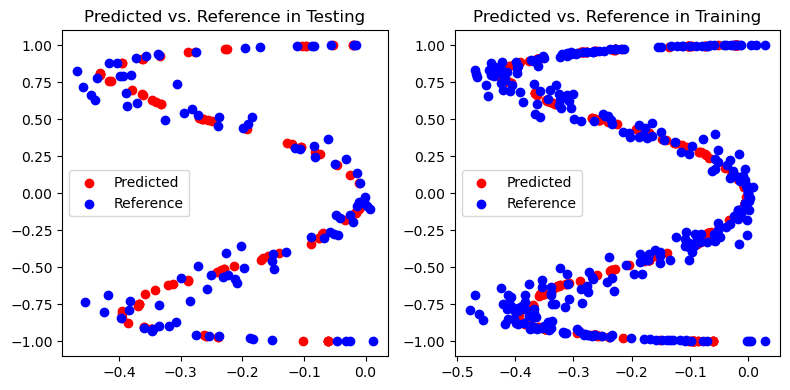

In [35]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs[0].scatter(forest_predictions.data[:,0], forest_predictions.data[:,1], color='red', label='Predicted')
axs[0].scatter(y_test.data[:,0], y_test.data[:,1], color='blue', label='Reference')
axs[0].legend()
axs[0].set_title('Predicted vs. Reference in Testing')
axs[1].scatter(forest_fitted.data[:,0], forest_fitted.data[:,1], color='red', label='Predicted')
axs[1].scatter(y_train.data[:,0], y_train.data[:,1], color='blue', label='Reference')
axs[1].legend()
axs[1].set_title('Predicted vs. Reference in Training')
plt.tight_layout()
plt.show()

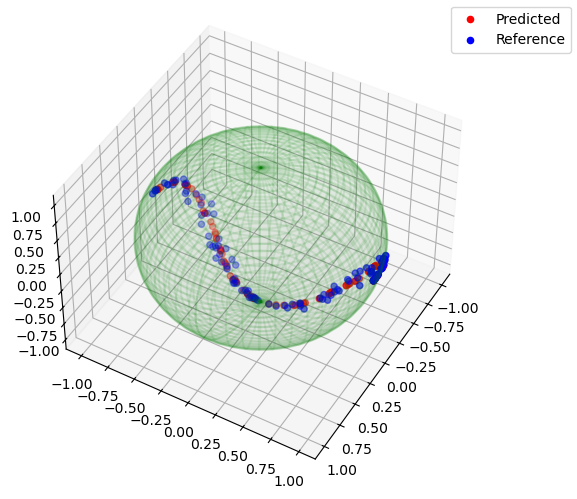

In [36]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[:,0],
            forest_predictions.data[:,1],
            forest_predictions.data[:,2], color='red', label='Predicted')
y_test_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(y_test.data)
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=45, azim=30)
fig.legend()
plt.tight_layout()
plt.show()

In [37]:
# Quantile for confidence balls
alpha=0.05
Dalpha=np.percentile(forest.oob_errors(), (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.94

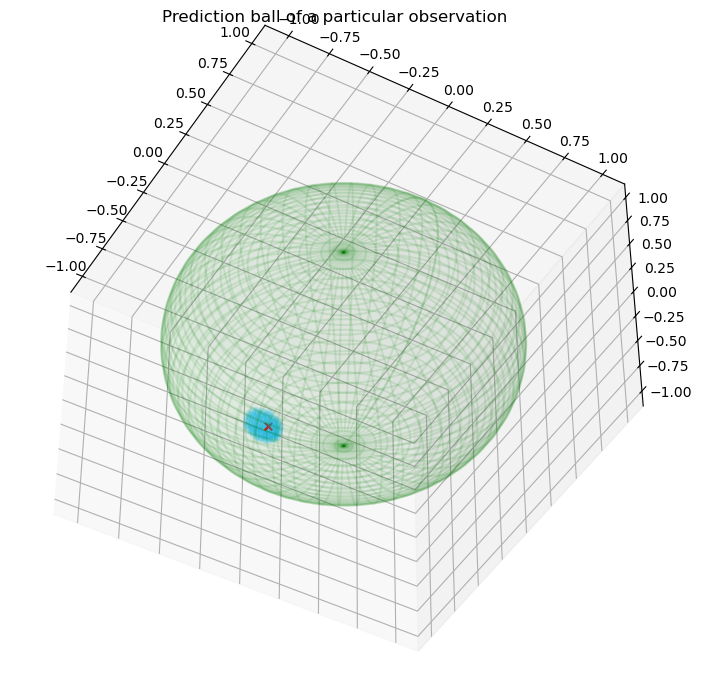

In [50]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, np.pi, 200)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure(figsize=(12,7))
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[25,0],
            forest_predictions.data[25,1],
            forest_predictions.data[25,2], marker='x', color='red', s=30, alpha=0)
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)


for i in range(z_grid.shape[0]):
    for j in range(z_grid.shape[1]):
        if forest_predictions.M.d(forest_predictions.data[25,:], np.array([x_grid[i,j], y_grid[i,j], z_grid[i,j]])) <= Dalpha:
            ax.scatter3D(x_grid[i,j], y_grid[i,j], z_grid[i,j], color='deepskyblue', alpha=0.1)

ax.scatter3D(y_test.data[25,0], y_test.data[25,1], y_test.data[25,2], marker='x', color='red', s=30, alpha=1)
ax.set_title('Prediction ball of a particular observation')

ax.view_init(elev=-45, azim=-30)
plt.tight_layout()
plt.show()

In [265]:
Dalpha

0.11293937567576057

### Sample 6

In [22]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='S2Data_sample6.csv'
sample6=pd.read_csv(path+file_name)
print(sample6.head())
print(sample6.shape)

     samp.1    samp.2    samp.3        ph    true.1    true.2    true.3
0  0.409140  0.912463 -0.004027  0.001397  0.410322  0.911929 -0.004544
1  0.407820  0.913055 -0.003584  0.002907  0.403791  0.914850 -0.001257
2  0.398806  0.917029  0.003382  0.014882  0.397283  0.917694  0.002143
3  0.379979  0.924995 -0.000159  0.033328  0.390799  0.920459  0.005654
4  0.381116  0.924508  0.005929  0.033483  0.384341  0.923145  0.009276
(400, 7)


In [23]:
M=Sphere(2)
X=sample6[['ph']].values
# X=(np.arange(sample1.shape[0])/sample1.shape[0]).reshape((-1,1))
y=MetricData(M, sample6[['samp.1', 'samp.2', 'samp.3']].values)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [11]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=-2)
forest.fit(X_train, y_train)

KeyboardInterrupt: 

In [33]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.016159744509139717
MSE: 0.010486820838271023


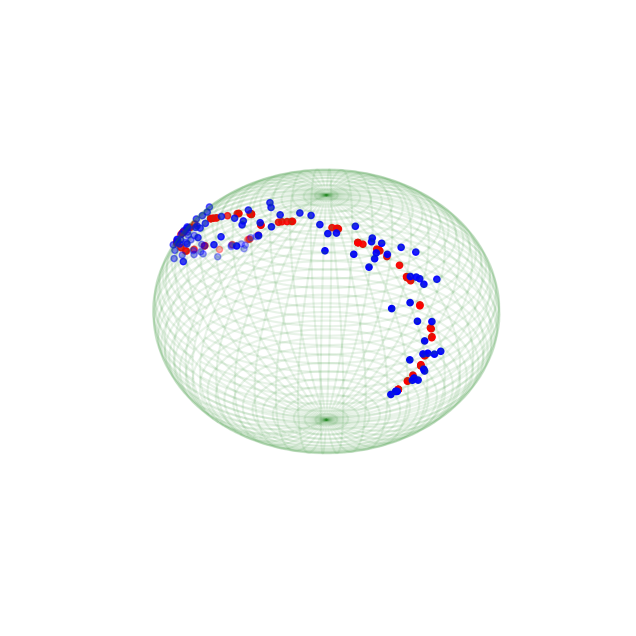

In [34]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100, endpoint=False)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[:,0],
            forest_predictions.data[:,1],
            forest_predictions.data[:,2], color='red', label='Predicted')
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=45)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
# fig.legend()
plt.show()

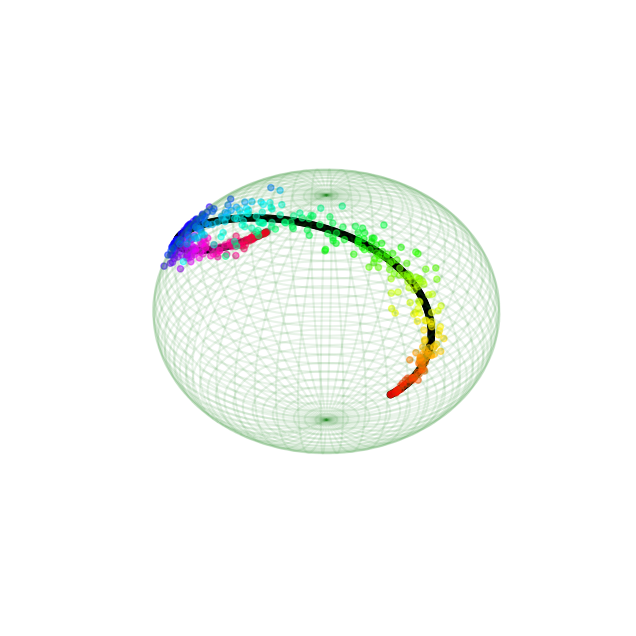

In [29]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100, endpoint=False)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(y.data[:,0],
            y.data[:,1],
            y.data[:,2], #color='blue', #label='Reference',
            alpha=0.5, c=np.arange(y.data.shape[0]), cmap='hsv')
ax.scatter3D(sample6['true.1'],
             sample6['true.2'],
             sample6['true.3'], color='black', alpha)
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=45)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.grid(False)


plt.show()

In [39]:
oob_errors=forest.oob_errors()

0.91


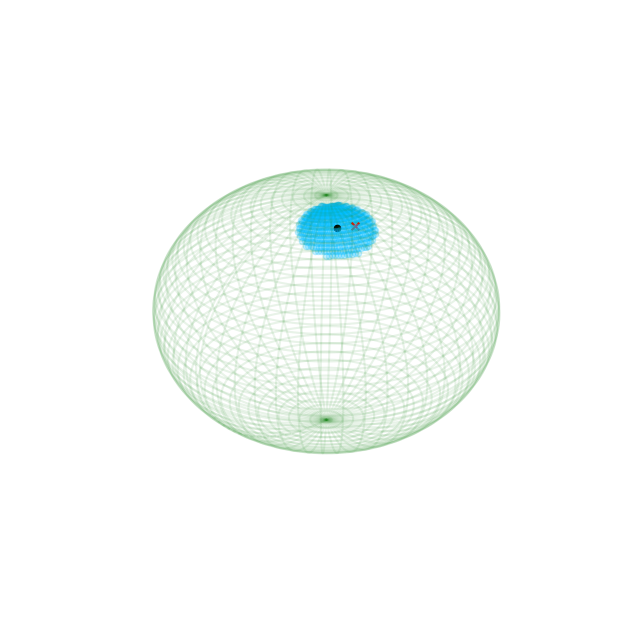

In [43]:
u = np.linspace(0, 2 * np.pi, 200, endpoint=False)
v = np.linspace(0, np.pi, 200//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))

fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[25,0],
            forest_predictions.data[25,1],
            forest_predictions.data[25,2], marker='x', color='red', s=30, alpha=0)
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)


for i in range(z_grid.shape[0]):
    for j in range(z_grid.shape[1]):
        if forest_predictions.M.d(forest_predictions.data[25,:], np.array([x_grid[i,j], y_grid[i,j], z_grid[i,j]])) <= Dalpha:
            ax.scatter3D(x_grid[i,j], y_grid[i,j], z_grid[i,j], color='deepskyblue', alpha=0.2)

ax.scatter3D(y_test.data[25,0], y_test.data[25,1], y_test.data[25,2], marker='x', color='red', s=30, alpha=1)
ax.scatter3D(forest_predictions.data[25,0], forest_predictions.data[25,1], forest_predictions.data[25,2], 
             marker='o', color='black', s=20, alpha=1)

ax.view_init(elev=30, azim=45)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')

plt.show()

In [37]:
# For to create the grid for the sphere
def create_S2_grid(grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    u = np.linspace(0, 2 * np.pi, grid_size, endpoint=False)
    v = np.linspace(0, np.pi, grid_size//2)
    x_grid = np.outer(np.cos(u), np.sin(v))
    y_grid = np.outer(np.sin(u), np.sin(v))
    z_grid = np.outer(np.ones(np.size(u)), np.cos(v))
    return (x_grid, y_grid, z_grid)

# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls(grid: tuple[np.ndarray, np.ndarray, np.ndarray],
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    
    for index_to_plot in indices_to_plot:
        ax.scatter3D(predictions[index_to_plot,0],
                predictions[index_to_plot,1],
                predictions[index_to_plot,2], marker='x', color='red', s=30, alpha=1)
        
        for i in range(grid[2].shape[0]):
            for j in range(grid[2].shape[1]):
                if M.d(predictions[index_to_plot,:], np.array([grid[0][i,j], grid[1][i,j], grid[2][i,j]])) <= Dalpha:
                    ax.scatter3D(grid[0][i,j], grid[1][i,j], grid[2][i,j], color=color, alpha=alpha) 

0.88


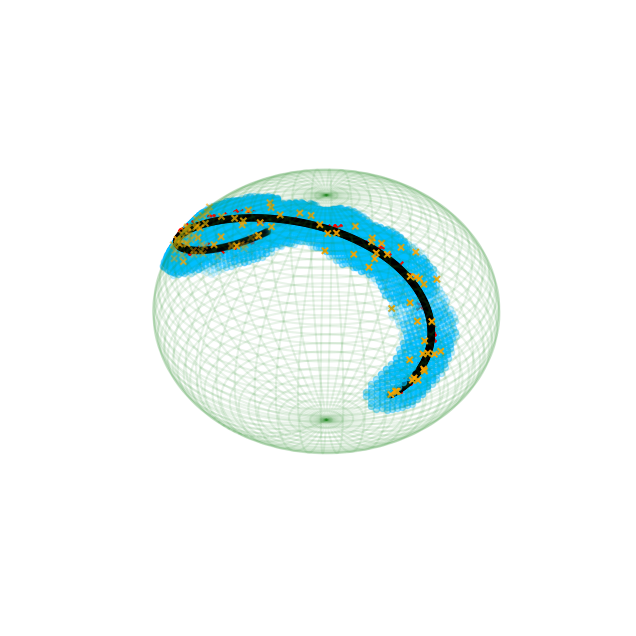

In [42]:
x_grid, y_grid, z_grid = create_S2_grid(grid_size=200)

alpha=0.10
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))

fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)

plot_OOB_balls((x_grid, y_grid, z_grid), 
               predictions=forest_predictions.data, 
               indices_to_plot=list(range(0,y_test.data.shape[0])), 
               Dalpha=Dalpha, 
               ax=ax,
               alpha=0.1)

ax.scatter3D(sample6['true.1'],
             sample6['true.2'],
             sample6['true.3'], color='black')
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='orange', marker='x')

ax.view_init(elev=30, azim=45)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')

plt.show()


### Creating plots

In [36]:
# For to create the grid for the sphere
def create_S2_grid(grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    u = np.linspace(0, 2 * np.pi, grid_size, endpoint=False)
    v = np.linspace(0, np.pi, grid_size//2)
    x_grid = np.outer(np.cos(u), np.sin(v))
    y_grid = np.outer(np.sin(u), np.sin(v))
    z_grid = np.outer(np.ones(np.size(u)), np.cos(v))
    return (x_grid, y_grid, z_grid)

# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls(grid: tuple[np.ndarray, np.ndarray, np.ndarray],
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    
    for index_to_plot in indices_to_plot:
        ax.scatter3D(predictions[index_to_plot,0],
                predictions[index_to_plot,1],
                predictions[index_to_plot,2], marker='x', color='red', s=30, alpha=1)
        
        for i in range(grid[2].shape[0]):
            for j in range(grid[2].shape[1]):
                if M.d(predictions[index_to_plot,:], np.array([grid[0][i,j], grid[1][i,j], grid[2][i,j]])) <= Dalpha:
                    ax.scatter3D(grid[0][i,j], grid[1][i,j], grid[2][i,j], color=color, alpha=alpha)

In [20]:
M=Sphere(2)
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'

# Spiral with low variance
file_name='S2Data_sample2.csv'
sample2=pd.read_csv(path+file_name)
X2=sample2[['ph']].values
# X=(np.arange(sample1.shape[0])/sample1.shape[0]).reshape((-1,1))
y2=MetricData(M, Hypersphere(dim=2).spherical_to_extrinsic(sample2[['samp.2', 'samp.1']].values))

# Circle with low variance
file_name='S2Data_sample1.csv'
sample1=pd.read_csv(path+file_name)
X1=sample1[['ph']].values
y1=MetricData(M, sample1[['samp.1', 'samp.2', 'samp.3']].values)

# Spiral with high variance
file_name='S2Data_sample4.csv'
sample4=pd.read_csv(path+file_name)
X4=sample4[['ph']].values
y4=MetricData(M, sample4[['samp.1', 'samp.2', 'samp.3']].values)

# Circle with high variance
file_name='S2Data_sample5.csv'
sample5=pd.read_csv(path+file_name)
X5=sample5[['ph']].values
y5=MetricData(M, sample5[['samp.1', 'samp.2', 'samp.3']].values)

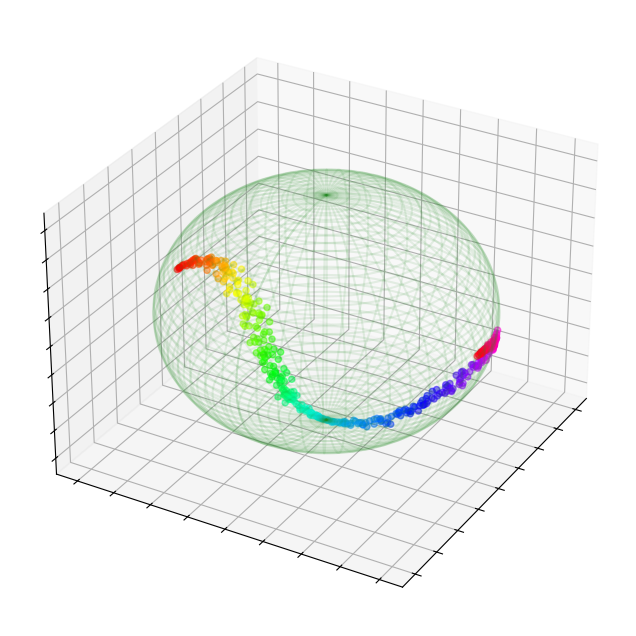

In [13]:
x_grid, y_grid, z_grid=create_S2_grid()

plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(y2.data[:,0],
            y2.data[:,1],
            y2.data[:,2], #color='blue', #label='Reference',
            alpha=0.5, c=np.arange(y2.data.shape[0]), cmap='hsv')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=30)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.grid(False)


plt.show()

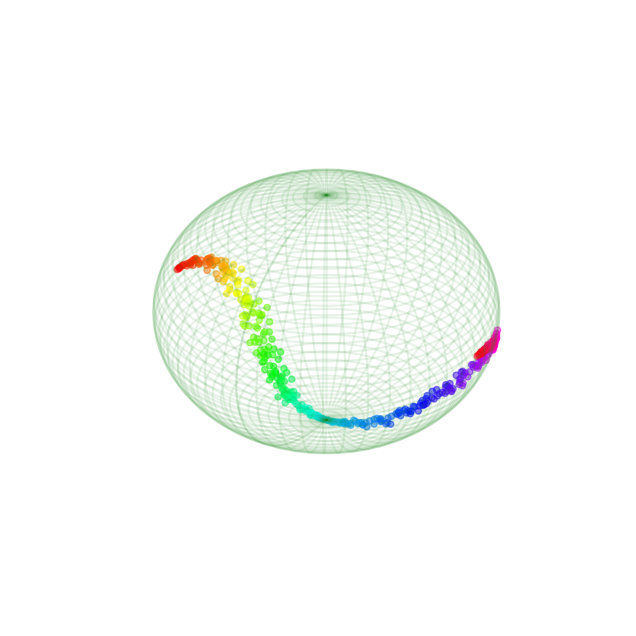

In [27]:
plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(y2.data[:,0],
            y2.data[:,1],
            y2.data[:,2], #color='blue', #label='Reference',
            alpha=0.5, c=np.arange(y2.data.shape[0]), cmap='hsv')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=30)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.grid(False)


plt.show()

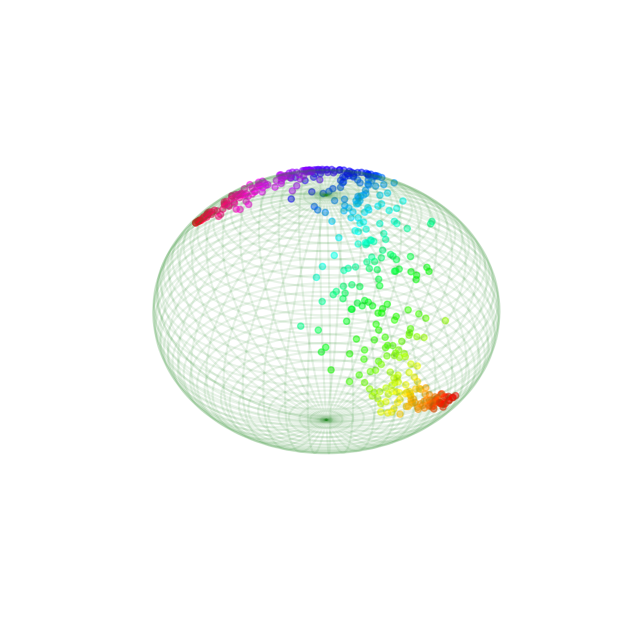

In [19]:
x_grid, y_grid, z_grid=create_S2_grid()

plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(y4.data[:,0],
            y4.data[:,1],
            y4.data[:,2], #color='blue', #label='Reference',
            alpha=0.5, c=np.arange(y2.data.shape[0]), cmap='hsv')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=100)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')


plt.show()

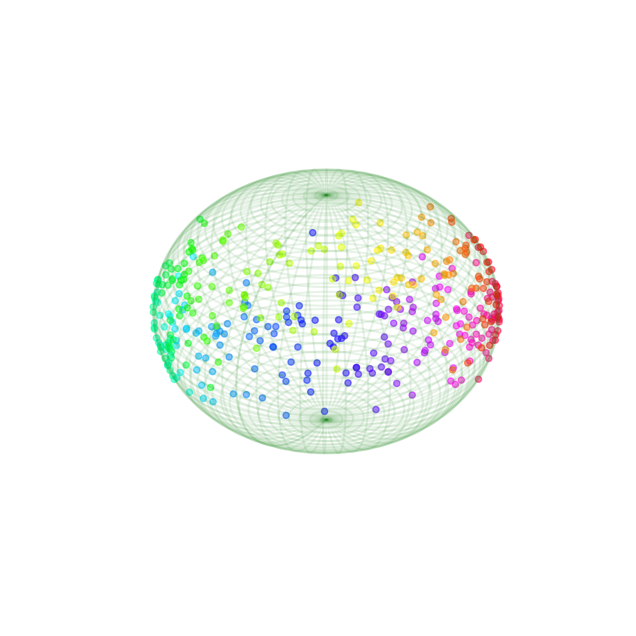

In [22]:
x_grid, y_grid, z_grid=create_S2_grid()

plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(y5.data[:,0],
            y5.data[:,1],
            y5.data[:,2], #color='blue', #label='Reference',
            alpha=0.5, c=np.arange(y2.data.shape[0]), cmap='hsv')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=30)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')


plt.show()

## Syntetic data on the Torus

### Sample 1

In [2]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='T2Data_sample1.csv'
sample1=pd.read_csv(path+file_name)
print(sample1.head())
print(sample1.shape)

    theta.1   theta.2         t    true.1    true.2
0  0.428848 -1.782199  0.011546  0.070607 -1.396685
1  0.402315 -1.304669  0.016183  0.102101 -1.412432
2  0.530236 -1.298252  0.016320  0.133596 -1.428180
3  0.054260 -1.890887  0.019021  0.165091 -1.443927
4  0.176482 -1.373367  0.019599  0.196585 -1.459674
(400, 5)


In [3]:
M=Torus(2)
X=sample1[['t']].values
y=MetricData(M, sample1[['theta.1','theta.2']].values)

In [4]:
def create_T2_grid(R: float, r: float, grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    u = np.linspace(0, 2*np.pi, grid_size, endpoint=True)
    v = np.linspace(0, 2*np.pi, grid_size, endpoint=False)
    u, v = np.meshgrid(u, v)

    x_grid = (R + r * np.cos(v)) * np.cos(u)
    y_grid = (R + r * np.cos(v)) * np.sin(u)
    z_grid = r * np.sin(v)

    return (x_grid, y_grid, z_grid)

def angles_to_T2(theta, phi, R: float, r: float) -> tuple:
    x_coord = (R + r * np.cos(theta)) * np.cos(phi)
    y_coord = (R + r * np.cos(theta)) * np.sin(phi)
    z_coord = r * np.sin(theta)

    return (x_coord, y_coord, z_coord)

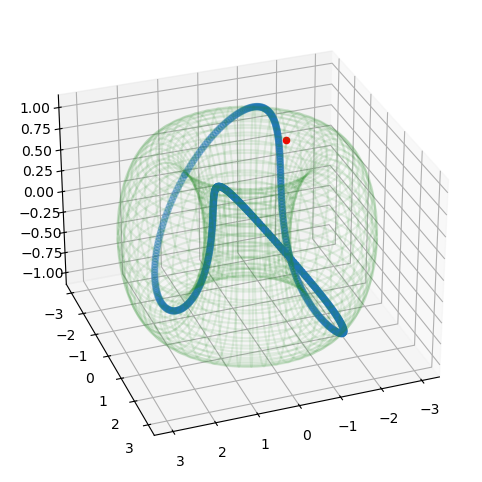

In [5]:
x_grid, y_grid, z_grid = create_T2_grid(R=2, r=1)

# x_coord, y_coord, z_coord=angles_to_T2(y.data[:,0], y.data[:,1], R=2, r=1)

x_coord, y_coord, z_coord=angles_to_T2(sample1[['true.1']].values, sample1[['true.2']].values, R=2, r=1)

fig=plt.figure(figsize=(10,6))
ax=plt.axes(projection='3d')
ax.scatter3D(x_coord,y_coord,z_coord)
x_mean, y_mean, z_mean=angles_to_T2(y.frechet_mean()[0], y.frechet_mean()[1], R=2, r=1)
ax.scatter(x_mean, y_mean, z_mean, color='red')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.view_init(elev=30, azim=70)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [7]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=-2)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(split_type='2means'))

In [8]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.2406517131896002


MSE: 0.13206330069293867


In [9]:
oob_errors=forest.oob_errors()

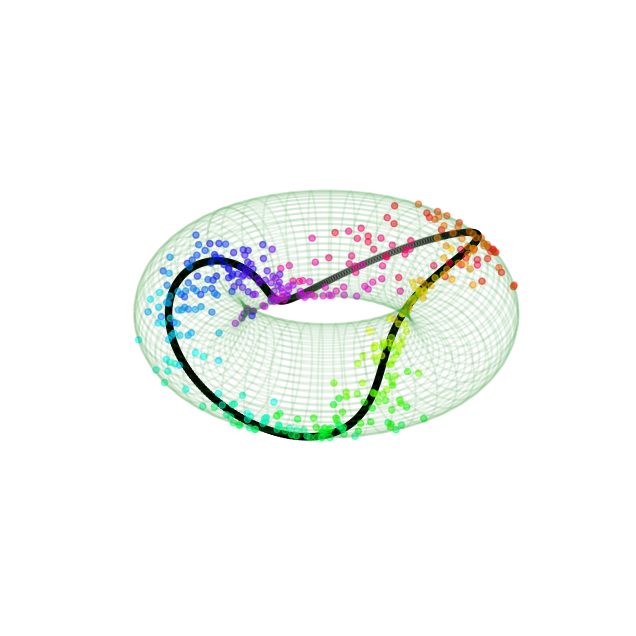

In [77]:
R=2.5; r=1

x_grid, y_grid, z_grid = create_T2_grid(R=R, r=r)
x_coord, y_coord, z_coord=angles_to_T2(y.data[:,0], y.data[:,1], R=R, r=r)

fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(x_coord,y_coord,z_coord, label='Prediction',
             alpha=0.5, c=np.arange(y.data.shape[0]), cmap='hsv')
x_coord, y_coord, z_coord=angles_to_T2(sample1['true.1'], sample1['true.2'], R=R, r=r)
ax.scatter3D(x_coord,y_coord,z_coord, color='black', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.set_box_aspect((np.ptp(x_grid), np.ptp(y_grid), np.ptp(z_grid)))
ax.view_init(elev=30, azim=140)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
plt.show()


#alpha=0.5, c=np.arange(y2.data.shape[0]), cmap='hsv'

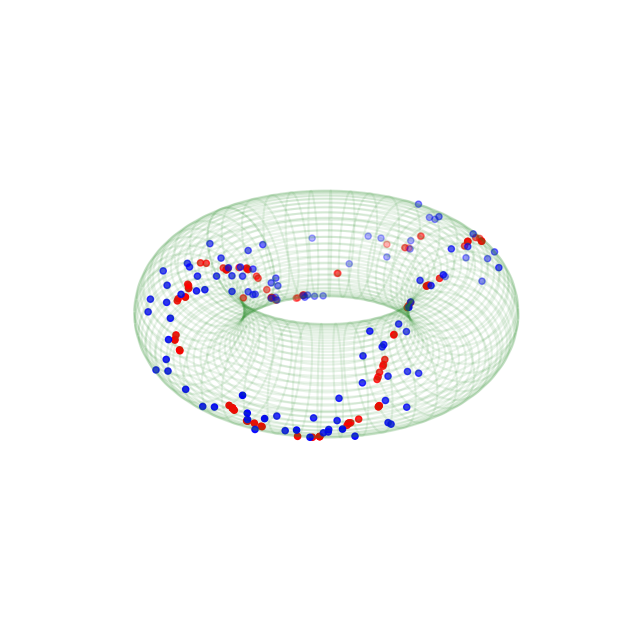

In [97]:
R=2.5; r=1

x_grid, y_grid, z_grid = create_T2_grid(R=R, r=r)
x_coord, y_coord, z_coord=angles_to_T2(forest_predictions.data[:,0], 
                                       forest_predictions.data[:,1], R=R, r=r)

fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.scatter3D(x_coord,y_coord,z_coord, color='red', label='Prediction')
x_coord, y_coord, z_coord=angles_to_T2(y_test.data[:,0], y_test.data[:,1], R=R, r=r)
ax.scatter3D(x_coord,y_coord,z_coord, color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='forestgreen', alpha=0.1)
ax.set_box_aspect((np.ptp(x_grid), np.ptp(y_grid), np.ptp(z_grid)))
ax.view_init(elev=30, azim=140)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
plt.show()

In [100]:
# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls_T2(predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   R=2, r=1,
                   grid_size: int=200,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    u = np.linspace(0, 2*np.pi, grid_size, endpoint=True)
    v = np.linspace(0, 2*np.pi, grid_size, endpoint=False)
    u, v = np.meshgrid(u, v)

    # x_grid = (R + r * np.cos(v)) * np.cos(u)
    # y_grid = (R + r * np.cos(v)) * np.sin(u)
    # z_grid = r * np.sin(v)

    for index_to_plot in indices_to_plot:
        x_coord, y_coord, z_coord=angles_to_T2(predictions[index_to_plot,0], predictions[index_to_plot,1], R=R, r=r)
        ax.scatter3D(x_coord, y_coord, z_coord, marker='o', color='black', s=30, alpha=1)
        
        # for i in range(z_grid.shape[0]):
        #     for j in range(z_grid.shape[1]):
        #         if M.d(predictions[index_to_plot], np.array([u[i,j], v[i,j]])) <= Dalpha:
        #             ax.scatter3D(x_grid[i,j], y_grid[i,j], z_grid[i,j], color=color, alpha=alpha)    

        for i in range(u.shape[0]):
            for j in range(v.shape[1]):
                if M.d(predictions[index_to_plot], np.array([u[i,j], v[i,j]])) <= Dalpha:
                    x_coord, y_coord, z_coord=angles_to_T2(u[i,j], v[i,j], R=R, r=r)
                    ax.scatter3D(x_coord, y_coord, z_coord, color=color, alpha=alpha)   

0.91


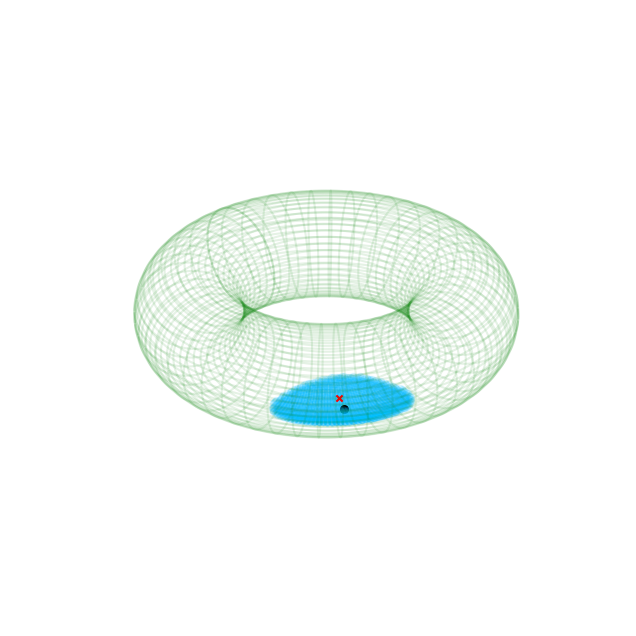

In [102]:
R=2.5; r=1

grid_size=200
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))

x_grid, y_grid, z_grid = create_T2_grid(R=R, r=r, grid_size=grid_size)
fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.set_box_aspect((np.ptp(x_grid), np.ptp(y_grid), np.ptp(z_grid)))

x_coord, y_coord, z_coord=angles_to_T2(y_test.data[40,0], 
                                       y_test.data[40,1], R=R, r=r)
ax.scatter3D(x_coord,y_coord,z_coord, color='red', label='Prediction', marker='x')
# Plot OOB balls
plot_OOB_balls_T2(predictions=forest_predictions.data, 
               indices_to_plot=[40], 
               Dalpha=Dalpha, 
               ax=ax,
               grid_size=grid_size)
ax.view_init(elev=30, azim=140)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
plt.show()

In [10]:
# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls_T2(predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   R=2, r=1,
                   grid_size: int=200,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    u = np.linspace(0, 2*np.pi, grid_size, endpoint=True)
    v = np.linspace(0, 2*np.pi, grid_size, endpoint=False)
    u, v = np.meshgrid(u, v)

    # x_grid = (R + r * np.cos(v)) * np.cos(u)
    # y_grid = (R + r * np.cos(v)) * np.sin(u)
    # z_grid = r * np.sin(v)

    for index_to_plot in tqdm(indices_to_plot, desc='Index'):
        x_coord, y_coord, z_coord=angles_to_T2(predictions[index_to_plot,0], predictions[index_to_plot,1], R=R, r=r)
        ax.scatter3D(x_coord, y_coord, z_coord, marker='o', color='black', s=30, alpha=0)
        
        # for i in range(z_grid.shape[0]):
        #     for j in range(z_grid.shape[1]):
        #         if M.d(predictions[index_to_plot], np.array([u[i,j], v[i,j]])) <= Dalpha:
        #             ax.scatter3D(x_grid[i,j], y_grid[i,j], z_grid[i,j], color=color, alpha=alpha)    

        for i in range(u.shape[0]):
            for j in range(v.shape[1]):
                if M.d(predictions[index_to_plot], np.array([u[i,j], v[i,j]])) <= Dalpha:
                    x_coord, y_coord, z_coord=angles_to_T2(u[i,j], v[i,j], R=R, r=r)
                    ax.scatter3D(x_coord, y_coord, z_coord, color=color, alpha=alpha)   

0.95


Index: 100%|██████████| 100/100 [09:31<00:00,  5.71s/it]


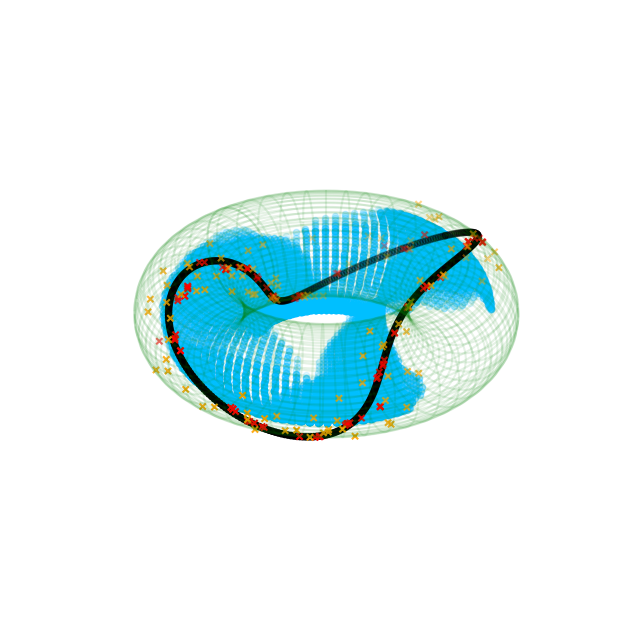

In [11]:
R=2.5; r=1

grid_size=100
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))

x_grid, y_grid, z_grid = create_T2_grid(R=R, r=r, grid_size=grid_size)
fig=plt.figure(figsize=(8,8))
ax=plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.set_box_aspect((np.ptp(x_grid), np.ptp(y_grid), np.ptp(z_grid)))

x_coord, y_coord, z_coord=angles_to_T2(sample1['true.1'], sample1['true.2'], R=R, r=r)
ax.scatter3D(x_coord,y_coord,z_coord, color='black', label='Reference', marker='o')

x_coord, y_coord, z_coord=angles_to_T2(forest_predictions.data[:,0], 
                                       forest_predictions.data[:,1], R=R, r=r)
ax.scatter3D(x_coord,y_coord,z_coord, color='red', label='Prediction', marker='x')

x_coord, y_coord, z_coord=angles_to_T2(y_test.data[:,0], y_test.data[:,1], R=R, r=r)
ax.scatter3D(x_coord, y_coord, z_coord, color='orange', marker='x')


# Plot OOB balls
plot_OOB_balls_T2(predictions=forest_predictions.data, 
               indices_to_plot=list(range(0,y_test.data.shape[0])), 
               Dalpha=Dalpha, 
               ax=ax,
               grid_size=grid_size,
               R=R, r=r)
ax.view_init(elev=30, azim=140)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.axis('off')
plt.show()

## Sunspots Dataset

In [3]:
path='C:/Users/J2404/OneDrive/Documentos/UNIVERSIDAD/MÁSTER/TFM/R (TFM)/'
file_name='sunspots_births.csv'
sunspots=pd.read_csv(path+file_name)
sunspots['date']=pd.to_datetime(sunspots['date'])
print(sunspots.head())
print(sunspots.info())

                 date  cycle  total_area  dist_sun_disc     theta       phi
0 1874-04-17 11:38:00     11         113          0.388  1.977458  0.101229
1 1874-04-27 13:20:01     11         171          0.899  5.166175 -0.216421
2 1874-04-30 13:50:01     11          24          0.284  5.785766  0.137881
3 1874-05-01 12:56:00     11          42          0.893  4.265585 -0.064577
4 1874-05-06 10:22:00     11         248          0.951  2.993240  0.113446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51303 entries, 0 to 51302
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           51303 non-null  datetime64[ns]
 1   cycle          51303 non-null  int64         
 2   total_area     51303 non-null  int64         
 3   dist_sun_disc  51303 non-null  float64       
 4   theta          51303 non-null  float64       
 5   phi            51303 non-null  float64       
dtypes: datetime64[ns](1), f

In [4]:
# We take the most recent solar cycle (namely, the 23rd)
sunspots_23=sunspots[sunspots.cycle==23]
sunspots_23=sunspots_23.reset_index(drop=True)
print(sunspots_23.head())
print(sunspots_23.info())

                 date  cycle  total_area  dist_sun_disc     theta       phi
0 1996-08-06 06:04:49     23           3         0.6975  2.888171  0.176453
1 1996-08-09 14:45:56     23           1         0.6115  3.535513  0.267384
2 1996-08-10 14:29:39     23           3         0.4550  2.317448  0.451691
3 1996-08-14 10:01:58     23          23         0.6005  1.237788  0.505622
4 1996-08-15 05:57:30     23           2         0.5478  1.010895  0.052360
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           5373 non-null   datetime64[ns]
 1   cycle          5373 non-null   int64         
 2   total_area     5373 non-null   int64         
 3   dist_sun_disc  5373 non-null   float64       
 4   theta          5373 non-null   float64       
 5   phi            5373 non-null   float64       
dtypes: datetime64[ns](1), flo

In [5]:
# The dates are ordered in the dateframe
print(sunspots_23.date.describe())
print(sunspots_23.date.head())
print(sunspots_23.date.tail())
sunspots_23['date'].is_monotonic_increasing

count                             5373
mean     2001-11-02 16:02:09.188162944
min                1996-08-06 06:04:49
25%                1999-11-06 12:47:33
50%                2001-07-15 10:18:04
75%                2003-06-27 07:07:35
max                2008-11-27 05:20:31
Name: date, dtype: object
0   1996-08-06 06:04:49
1   1996-08-09 14:45:56
2   1996-08-10 14:29:39
3   1996-08-14 10:01:58
4   1996-08-15 05:57:30
Name: date, dtype: datetime64[ns]
5368   2008-11-03 06:58:07
5369   2008-11-11 10:58:11
5370   2008-11-11 10:58:11
5371   2008-11-20 08:17:34
5372   2008-11-27 05:20:31
Name: date, dtype: datetime64[ns]


True

In [6]:
# We convert the time to a float from the datetimes by normalizing them
min_date=sunspots_23['date'].min()
max_date=sunspots_23['date'].max()
sunspots_23['date']=(sunspots_23['date'] - min_date)/(max_date - min_date)
sunspots_23['date']

0       0.000000
1       0.000748
2       0.000968
3       0.001816
4       0.002001
          ...   
5368    0.994677
5369    0.996493
5370    0.996493
5371    0.998470
5372    1.000000
Name: date, Length: 5373, dtype: float64

In [7]:
sunspots_23=sunspots_23.sample(n=2000)
M=Sphere(2)
X=sunspots_23[['date','total_area','dist_sun_disc']].values
y=MetricData(M, Hypersphere(dim=2).spherical_to_extrinsic(sunspots_23[['theta','phi']].values))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

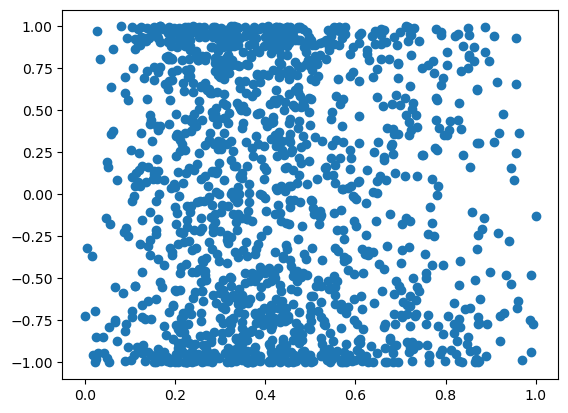

In [43]:
plt.figure()
plt.scatter(X_train[:,0], y_train.data[:,2])
plt.show()

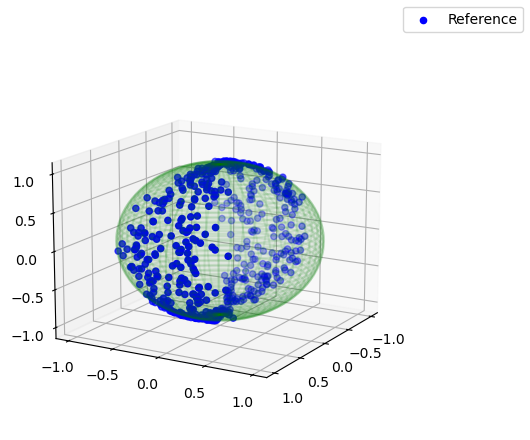

In [45]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=15, azim=30)
fig.legend()

plt.show()

In [46]:
base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=None,
            min_split_size=15)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4,
                         verbose_parallel=1)
forest.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done 879 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-2)]: Done 1400 out of 1400 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 35.6min finished


BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(impurity_method='medoid', min_split_size=15,
                               split_type='2means'),
                n_jobs=4, verbose_parallel=1)

In [49]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

MSE: 2.905872012297972


In [48]:
forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 2.1749928378541563


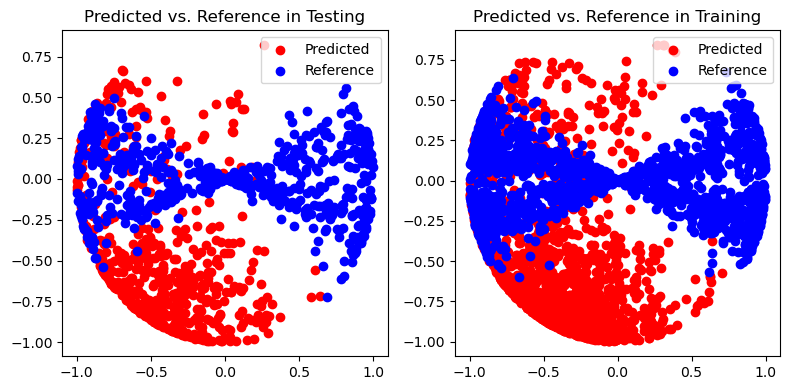

In [68]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs[0].scatter(forest_predictions.data[:,0], forest_predictions.data[:,1], color='red', label='Predicted')
axs[0].scatter(y_test.data[:,0], y_test.data[:,1], color='blue', label='Reference')
axs[0].legend()
axs[0].set_title('Predicted vs. Reference in Testing')
axs[1].scatter(forest_fitted.data[:,0], forest_fitted.data[:,1], color='red', label='Predicted')
axs[1].scatter(y_train.data[:,0], y_train.data[:,1], color='blue', label='Reference')
axs[1].legend()
axs[1].set_title('Predicted vs. Reference in Training')
plt.tight_layout()
plt.show()

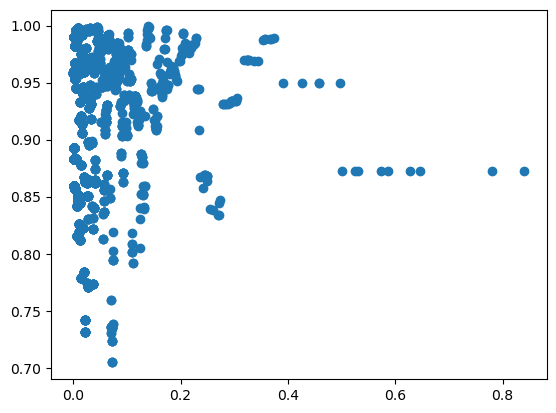

In [120]:
plt.figure()
plt.scatter(X_test, forest_predictions.data[:,1])
plt.show()

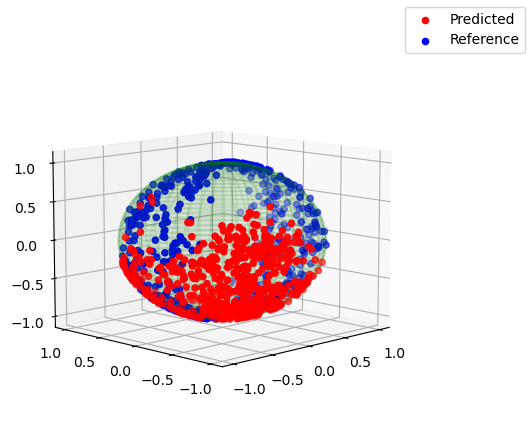

In [69]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100//2)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(forest_predictions.data[:,0],
            forest_predictions.data[:,1],
            forest_predictions.data[:,2], color='red', label='Predicted')
y_test_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(y_test.data)
ax.scatter3D(y_test.data[:,0],
            y_test.data[:,1],
            y_test.data[:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=10, azim=225)
fig.legend()

plt.show()

In [55]:
oob_errors=forest.oob_errors()

In [56]:
# Quantile for confidence balls
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.97